# Naive Bayes Classifier

In [1]:
from cStringIO import StringIO
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from os import path
from PIL import Image
from sklearn.metrics import confusion_matrix
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier
from wordcloud import WordCloud, STOPWORDS
import itertools
import nltk
import numpy as np
import matplotlib.pyplot as plt
import re
import sys

## Setup Classifier:

### Read Text File

In [2]:
# Read in Yelp text file and split into tuples with string and class
with open('yelp_labelled.txt', "r") as txt:
    text = txt.read().splitlines()
text = [tuple(line.split('\t')) for line in text]
save = text[:]

### Setup Stopwords, Stemmer, and Functions

In [3]:
# Set up stopwords and stemmer
stopWords = stopwords.words('english')
stopWords.extend(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', '...', '\'\'', '``', '-', 
                  'vegas', 'food', 'restaurant', 'place', 'service'])
stopWords = [s for s in stopWords if s not in ('not', 'until', 'against')]
ps = PorterStemmer()

# Set up function defs to find frequencies
def get_words(text):
    all_words = []
    for (words, sentiment) in text:
        all_words.extend(words)
    return all_words

# Setup function to capture output of most informative features
class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

### Tokenize, Remove Stopwords, and Stem Strings

In [4]:
# Remove stop words and stem strings
for i in range(len(text)):
    words = word_tokenize(text[i][0])
    stringFiltered = ''

    for w in words:
        if w.lower().encode() not in stopWords and re.match("\w*\'\w*", w) is None:
            stringFiltered += ps.stem(w.lower()).encode() + ' '
    
    text[i] = (stringFiltered, text[i][1])
    
# Split each review into a list of words
splitText = []

for i in range(len(text)):
    words = text[i][0].split()
    splitText.append(tuple((words, text[i][1])))

### Train and Test Classifier

In [5]:
# Split data into training and testing sets
train = text[300:1000]#text[0:][::2]
test = text[0:300]#text[1:][::2]

# Train classifier with train data
NB = NaiveBayesClassifier(train)

# Calculate accuracy of classifier with saved test data
print('Accuracy: ' + str(NB.accuracy(test) * 100) + '%\n')

Accuracy: 82.0%



## Visualizations:

### Probability Distributions of Test Data

In [6]:
# Show examples of probability distribution
for i in range(10):
    print('{}\n\t Positive: {}%; Negative: {}%\n'.
        format(save[i][0], round(NB.prob_classify(test[i][0]).prob('1')*100, 2), 
        round(NB.prob_classify(test[i][0]).prob('0')*100, 2)))

Wow... Loved this place.
	 Positive: 96.74%; Negative: 3.26%

Crust is not good.
	 Positive: 18.07%; Negative: 81.93%

Not tasty and the texture was just nasty.
	 Positive: 8.45%; Negative: 91.55%

Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.
	 Positive: 97.28%; Negative: 2.72%

The selection on the menu was great and so were the prices.
	 Positive: 99.95%; Negative: 0.05%

Now I am getting angry and I want my damn pho.
	 Positive: 19.16%; Negative: 80.84%

Honeslty it didn't taste THAT fresh.)
	 Positive: 67.19%; Negative: 32.81%

The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.
	 Positive: 47.77%; Negative: 52.23%

The fries were great too.
	 Positive: 98.47%; Negative: 1.53%

A great touch.
	 Positive: 97.61%; Negative: 2.39%



### Positive and Negative Word Clouds

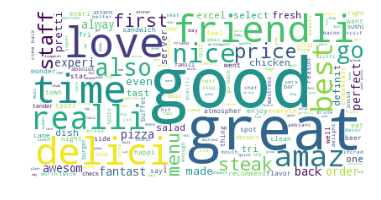

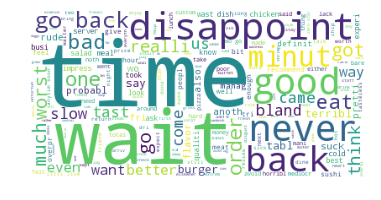

In [7]:
# Split text by positive and negative sentiments
posDoc, negDoc = '', ''

for w in range(len(text)):
    if text[w][1] == '1':
        posDoc = posDoc + text[w][0]
    else:
        negDoc = negDoc + text[w][0]

# Create word clouds of positive and negative words
posCloud = WordCloud(background_color='white').generate(posDoc)
negCloud = WordCloud(background_color='white').generate(negDoc)

plt.imshow(posCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

plt.imshow(negCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Actual vs Classified Sentiment Distributions

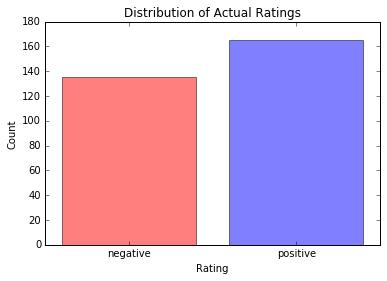

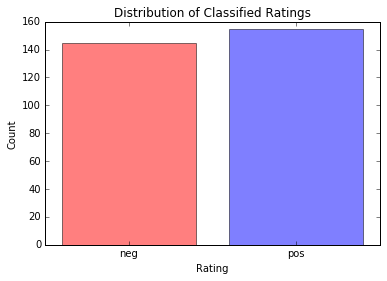

In [8]:
# Split test data by positive and negative sentiments
pos1, neg1, pos2, neg2 = 0, 0, 0, 0
actualRatings, classedRatings = [], []

for c in range(len(test)):
    actualRatings.append(test[c][1])
    if actualRatings[c] == '1':
        pos1 += 1
    else:
        neg1 += 1
    classedRatings.append(NB.classify(test[c][0]))
    if classedRatings[c] == '1':
        pos2 += 1
    else:
        neg2 += 1

# Plot distribution of actual ratings vs distribution of classified ratings
plt.bar([1, 2], [neg1, pos1], align = 'center', color=['red', 'blue'], alpha = 0.5)
plt.xticks([1, 2], ['negative', 'positive'])
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Actual Ratings')

plt.show()

plt.bar([1, 2], [neg2, pos2], align = 'center', color=['red', 'blue'], alpha = 0.5)
plt.xticks([1, 2], ['neg', 'pos'])
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Classified Ratings')

plt.show()

### Test Data Confusion Matrix

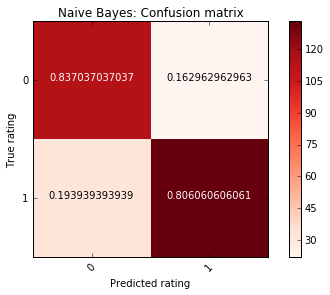

In [9]:
# Plot a confusion matrix
class_names = [0,1]

# This function prints and plots the confusion matrix.
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    # Normalization can be applied by setting `normalize=True`.
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True rating')
    plt.xlabel('Predicted rating')

# Compute confusion matrix
cnf_matrix = confusion_matrix(actualRatings[0:], classedRatings[0:])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Naive Bayes: Confusion matrix')
plt.show()

### Most Frequent Words

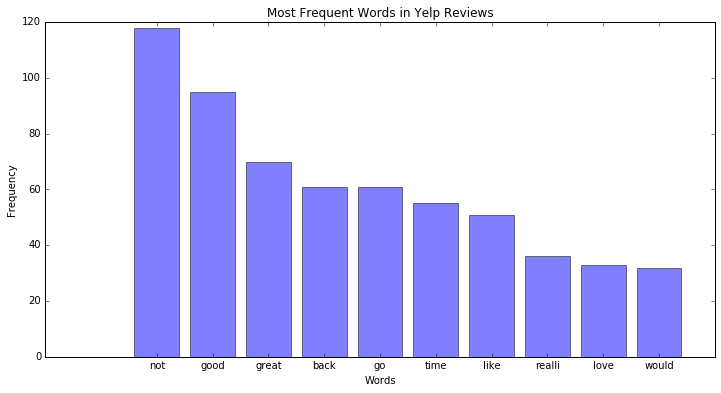

In [10]:
# Generate word frequencies
frequency = nltk.FreqDist(get_words(splitText))

# Extract top 10 words and their frequencies
topWords = frequency.most_common(10)
topFreq = []

for i in range(len(topWords)):
    topFreq.append(topWords[i][1])
    topWords[i] = topWords[i][0]
    
# Plot the top 10 words with the highest frequencies
y_pos = np.arange(len(topWords))

plt.figure(figsize=(12, 6))
plt.bar(y_pos, topFreq, align = 'center', alpha = 0.5)
plt.xticks(y_pos, topWords)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Most Frequent Words in Yelp Reviews')

plt.show()

### Most Informative Features and Likelihood Ratios

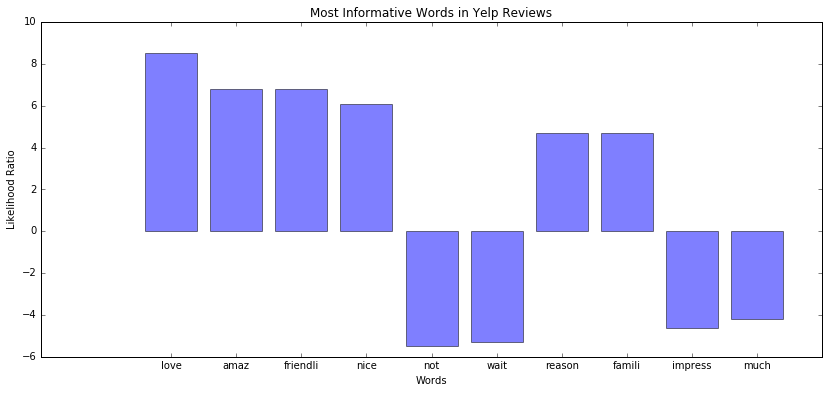

In [11]:
# Capture most informative features
with Capturing() as output:
    NB.show_informative_features(10)
#NB.show_informative_features(10)

# Format captured output into features and ratios
features = []
ratios = []

for w in range(len(output)):
    features.append(output[w][output[w].rfind('(')+1:output[w].rfind(')')])
    if re.search('0 : 1', output[w]) is None:
        ratios.append(output[w][output[w].rfind('=')+1:output[w].rfind(' : 1.0')].strip())
    else:
        ratios.append('-' + output[w][output[w].rfind('=')+1:output[w].rfind(' : 1.0')].strip())

features.remove(features[0])
ratios.remove(ratios[0])

# Plot the top 10 words with the highest likelihood ratios
y_pos = np.arange(len(features))

plt.figure(figsize=(14, 6))
plt.bar(y_pos, ratios, align = 'center', alpha = 0.5)
plt.xticks(y_pos, features)
plt.xlabel('Words')
plt.ylabel('Likelihood Ratio')
plt.title('Most Informative Words in Yelp Reviews')

plt.show()